In [1]:
import pickle
with open('Xs.pkl', 'rb') as f:
    Xs = pickle.load(f)
with open('X_stat_s.pkl', 'rb') as f:
    X_stat = pickle.load(f)
with open('ys.pkl', 'rb') as f:
    ys = pickle.load(f)

# Read data

In [56]:
import torch
import numpy as np

flattened_Xs = [torch.tensor(X).view(-1, 14) for X in Xs]  # Flatten to (*, 14)
all_X = torch.cat(flattened_Xs, dim=0)  # Shape: (total_samples, 14)

# Compute the max and min along the last dimension (14 features)
X_min = all_X.min(dim=0).values
X_max = all_X.max(dim=0).values

print("Global Min per feature:", X_min)
print("Global Max per feature:", X_max)

Global Min per feature: tensor([-9.2439e+03,  8.0000e-02,  1.0000e-02,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00, -5.3000e+03, -6.2430e+03, -1.4400e+04,
        -5.0840e+00, -5.0761e+05, -1.1806e+01, -2.0000e+01],
       dtype=torch.float64)
Global Max per feature: tensor([5.6626e+04, 9.9669e+01, 3.5490e+00, 2.0001e+06, 2.2698e+01, 1.6517e+05,
        1.2647e+02, 7.7400e+02, 1.0000e+00, 1.5350e+02, 2.3790e+00, 4.3896e+01,
        1.7008e+01, 3.6015e+04], dtype=torch.float64)


In [57]:
Xs_ = []
X_stat_s_ = []
ys_ = []

for X, x_stat, y in zip(Xs, X_stat, ys):
    X_tensor = torch.tensor(X)  # Shape: (N_t, 5, 14)
    x_stat_tensor = torch.tensor(x_stat) / torch.tensor([1, 1, 10, 100])
    y_tensor = torch.tensor(y)

    # Normalize X using global min and max (X_min and X_max) for each of the 14 features
    X_normalized = (X_tensor - X_min.unsqueeze(0).unsqueeze(0)) / (X_max.unsqueeze(0).unsqueeze(0) - X_min.unsqueeze(0).unsqueeze(0) + 1e-6)
    # `X_min.unsqueeze(0).unsqueeze(0)` now has shape (1, 1, 14), broadcasting across `N_t` and `5`

    # Append the normalized data to the lists
    Xs_.append(X_normalized)
    X_stat_s_.append(x_stat_tensor)
    ys_.append(y_tensor)

    # Check for NaNs in the normalized data
    print(X_normalized.isnan().any(), x_stat_tensor.isnan().any(), y_tensor.isnan().any())

tensor(False) tensor(False) tensor(False)
tensor(False) tensor(False) tensor(False)
tensor(False) tensor(False) tensor(False)
tensor(False) tensor(False) tensor(False)
tensor(False) tensor(False) tensor(False)
tensor(False) tensor(False) tensor(False)
tensor(False) tensor(False) tensor(False)
tensor(False) tensor(False) tensor(False)
tensor(False) tensor(False) tensor(False)
tensor(False) tensor(False) tensor(False)
tensor(False) tensor(False) tensor(False)
tensor(False) tensor(False) tensor(False)
tensor(False) tensor(False) tensor(False)
tensor(False) tensor(False) tensor(False)
tensor(False) tensor(False) tensor(False)
tensor(False) tensor(False) tensor(False)
tensor(False) tensor(False) tensor(False)
tensor(False) tensor(False) tensor(False)
tensor(False) tensor(False) tensor(False)
tensor(False) tensor(False) tensor(False)
tensor(False) tensor(False) tensor(False)
tensor(False) tensor(False) tensor(False)
tensor(False) tensor(False) tensor(False)
tensor(False) tensor(False) tensor

# Modeling

In [58]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class StockLSTMModel(nn.Module):
    def __init__(self, d_ts, d_static=4, hidden_size=256, d_factor=4):
        super(StockLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.d_factor = d_factor

        self.use_static = True

        # Two-layer LSTM for time-series data (single stock)
        self.lstm = nn.LSTM(input_size=d_ts, hidden_size=hidden_size, num_layers=2, batch_first=True)

        # MLP to process concatenated [LSTM output, static features]
        self.final_mlp_alpha = nn.Linear(hidden_size + d_static , 1)  # Producing alpha (1,)
        self.final_mlp_beta = nn.Linear(hidden_size + d_static , d_factor)  # Producing Beta (d_factor,)
        self.final_mlp_sigma = nn.Linear(hidden_size + d_static , 1)  # Producing sigma (1,)
        self.final_mlp_nu = nn.Linear(hidden_size + d_static , 1)  # Producing nu (1,)

    def forward(self, time_series_data, static_features):
        """
        Args:
            time_series_data: Tensor of shape (1, l, d_ts), time-series data for a single stock.
            static_features: Tensor of shape (1, d_static), static features for the same stock.

        Returns:
            alpha: Tensor of shape (1,), alpha for the stock.
            beta: Tensor of shape (d_factor,), beta for the stock.
            sigma: Tensor of shape (1,), positive volatility for the stock.
            nu: Tensor of shape (1,), degrees of freedom for the t-distribution.
        """
        lstm_out, (h_n, c_n) = self.lstm(time_series_data)  # lstm_out: (1, l, hidden_size)
        lstm_summary = h_n[-1]  # Shape: (1, hidden_size)

        combined_features = torch.cat((lstm_summary, static_features), dim=1)  # Shape: (1, hidden_size + d_static)

        alpha = self.final_mlp_alpha(combined_features).squeeze(-1)  # Shape: (1,)
        beta = self.final_mlp_beta(combined_features).squeeze(0)  # Shape: (d_factor,)
        sigma = torch.exp(self.final_mlp_sigma(combined_features)).squeeze(-1)  # Ensure sigma is positive (1,)
        nu = F.softplus(self.final_mlp_nu(combined_features)).squeeze(-1) + 4  # Ensure nu > 4 for t-distribution with finite kurtosis (1,)
        #nu = torch.floor(nu)

        return alpha, beta, sigma, nu


In [59]:
def mahalanobis(delta, cov):
    left = torch.matmul(delta, torch.inverse(cov))
    # (num_samples, n_factor) @ (n_factor, n_factor) = (num_samples, n_factor)
    m = (left * delta).sum(dim=1)
    # (num_samples, n_factor) * (num_samples, n_factor) . sum(1) = (num_samples,)
    return m

class FactorModelVAE(nn.Module):
    def __init__(self, d_ts, d_static, hidden_size=256, d_factor=4, num_samples=20):
        super(FactorModelVAE, self).__init__()
        self.lstm_model = StockLSTMModel(d_ts, d_static, hidden_size, d_factor)
        self.d_factor = d_factor
        self.num_samples = num_samples

        self.mu_z_prior = torch.zeros(d_factor)  # Shape: (d_factor,)
        self.Sigma_z_prior = torch.eye(d_factor)  # Shape: (d_factor, d_factor)

        self.nu_prior = 10

    def forward(self, time_series_data, static_features, r_future, Sigma_z):

        alphas, betas, sigmas, nus = [], [], [], []
        N_t = time_series_data.size(0)

        for i in range(N_t):
            stock_time_series = time_series_data[i].unsqueeze(0)  # Shape: (1, l, d_ts)
            stock_static = static_features[i].unsqueeze(0)  # Shape: (1, d_static)

            alpha, beta, sigma, nu = self.lstm_model(stock_time_series, stock_static)
            alphas.append(alpha)
            betas.append(beta)
            sigmas.append(sigma)
            nus.append(nu)

        alphas = torch.cat(alphas, dim=0)  # Shape: (N_t,)
        betas = torch.stack(betas, dim=0)  # Shape: (N_t, F)
        sigmas = torch.cat(sigmas, dim=0)  # Shape: (N_t,)
        nus = torch.cat(nus, dim=0)  # Shape: (N_t,)

        print('[[MONITOR]]', 'max', torch.max(sigmas), 'Q1', torch.quantile(sigmas, 0.25), 'Q2', torch.quantile(sigmas, 0.5), 'Q3', torch.quantile(sigmas, 0.75), 'NaNs vs N_t', torch.sum(torch.isnan(sigmas)).item(), N_t)

        mu_z_post, Sigma_z_post = self.qzx_parameters(alphas, betas, sigmas, nus,
                                                      self.mu_z_prior, self.Sigma_z_prior,
                                                      r_future)
        z_samples = self.sample_z(mu_z_post, Sigma_z_post)

        loss_qzx = self.log_qzx(z_samples, mu_z_post, Sigma_z_post)
        loss_pz = self.log_pz(z_samples, self.Sigma_z_prior, self.mu_z_prior)
        loss_pyz = self.log_pyz(r_future, alphas, betas, sigmas, nus, z_samples)

        log_weights = loss_pz + loss_pyz - loss_qzx
        log_sum_exp = torch.logsumexp(log_weights/self.num_samples, dim=0)  # Scalar

        return log_sum_exp

    def qzx_parameters(self, alphas, betas, sigmas, nus,
                       mu_z_prior, Sigma_z_prior,
                       r_future):

        Sigma_z_prior_inv = torch.inverse(Sigma_z_prior)
        Sigma_x_t_inv = torch.diag(1.0 / (sigmas))

        Sigma_z_post = torch.inverse(
            Sigma_z_prior_inv + betas.T @ Sigma_x_t_inv @ betas
        )
        # $Sigma_{z|B,t}$
        # betas (N_t, F) while BTSB (F, N_t)@(N_t, N_t)@(N_t, F)

        mu_z_post = Sigma_z_prior_inv @ mu_z_prior + betas.T @ Sigma_x_t_inv @ (r_future-alphas)
        mu_z_post = Sigma_z_post @ mu_z_post
        # no name given to this poor thing
        # (F,F)@(F,) + (F,N_t)@(N_t,N_t)@(N_t,) = (F,)

        return mu_z_post, Sigma_z_post

    def sample_z(self, mu_z_post, Sigma_z_post, num_samples=20):
        # mu_z_post - (F,)
        # Sigma_z_post - (F,F)

        std = torch.sqrt(torch.diagonal(Sigma_z_post).clamp(min=1e-6))
        # (d_factor,)
        eps = torch.randn((num_samples, self.d_factor), device=mu_z_post.device)
        # (num_samples, d_factor)

        z_samples = mu_z_post.unsqueeze(0) + eps * std.unsqueeze(0)
        # <<broadcasting>>
        # (1,F) ++ (num_samples, F)**(1, F) = (num_samples)
        return z_samples

    def log_qzx(self, z_samples, mu_z_post, Sigma_z_post):
        """
        q(z|x) is a the normal approx
        """
        diff = z_samples - mu_z_post.unsqueeze(0)
        # (num_samples,F) -- (1,F) = (num_samples, F)
        mhlnbs = mahalanobis(diff, Sigma_z_post + torch.eye(Sigma_z_post.size(0)) * 1e-6)
        # (num_samples, )

        log_det_sigma = torch.logdet(Sigma_z_post + torch.eye(Sigma_z_post.size(0))*1e-6)
        # (1,)

        log_prob = -0.5 * (mhlnbs + log_det_sigma)
        # (num_samples,) ++ (1,) = (num_samples,)

        return log_prob

    def log_pz(self, z_samples, Sigma_z_prior, mu_z_prior):
        """
        prior of z, t-distributed
        """
        diff = z_samples - mu_z_prior.unsqueeze(0)
        # (num_samples, d_factor)
        mhlnbs = mahalanobis(diff, Sigma_z_prior + torch.eye(Sigma_z_prior.size(0)) * 1e-6)
        #(num_samples,)

        log_prob = -0.5 * (self.nu_prior + self.d_factor) * torch.log(1 + mhlnbs / self.nu_prior)
        # (num_samples,)
        return log_prob

    def log_pyz(self, r_future, alphas, betas, sigmas, nus, z_samples):
        """
        decoder - p(y|z) - t-distributed
        """

        mean = alphas.unsqueeze(0) + torch.mm(z_samples, betas.T)
        # (1,N_t) + (num_samples, F)@(N_t, F).T
        # = (1,N_t) + (num_samples, N_t)
        residuals = r_future.unsqueeze(0) - mean
        # (1, N,t) - (num_samples, N_t)
        scaled_residuals = residuals / sigmas.unsqueeze(0)
        # (num_samples, N_t)

        log_prob = -0.5 * (nus.unsqueeze(0) + 1) * torch.log(1 + (scaled_residuals ** 2) / nus.unsqueeze(0))
        # (num_samples, N_t)
        log_prob = log_prob.sum(dim=1)
        # sum across stocks
        return log_prob



In [60]:
#Xs[0].shape

In [61]:
# Define the dimensions of your input data
d_ts = Xs[0].shape[2]  # Number of time-series features (e.g., financial ratios)
d_static = 4  # Number of static features (e.g., company information)
hidden_size = 256  # Hidden size for the LSTM
d_factor = 4  # Latent dimension size (number of latent factors) -
num_samples = 20

print('d_ts = ', d_ts)

def initialize_lstm_weights(lstm):
    for name, param in lstm.named_parameters():
        if 'weight' in name:
            nn.init.xavier_normal_(param)  # Xavier initialization for weights
        elif 'bias' in name:
            nn.init.constant_(param, 0)

# Instantiate the model
model = FactorModelVAE(d_ts=d_ts, d_static=d_static, hidden_size=hidden_size, d_factor=d_factor, num_samples=num_samples)
initialize_lstm_weights(model.lstm_model)

from torch.utils.data import Dataset

class StockDataset(Dataset):
    def __init__(self, Xs, ys):
        self.Xs = Xs
        self.ys = ys

    def __len__(self):
        # Return the number of samples (size of dataset)
        return len(self.Xs)

    def __getitem__(self, idx):
        # Fetch the sample and its label at index `idx`
        X = torch.tensor(self.Xs[idx], dtype=torch.float32)  # Convert to PyTorch tensor
        y = torch.tensor(self.ys[idx], dtype=torch.float32)
        return X, y


#stock_dataset = StockDataset(Xs, ys)

# Create the DataLoader for batching
#batch_size = 32  # You can adjust the batch size
#stock_dataloader = DataLoader(stock_dataset, batch_size=batch_size, shuffle=True)


d_ts =  14


In [62]:
X_stat_s_[1]

tensor([[ 3.0000, 38.0000, 38.2000, 38.2500],
        [ 3.0000, 33.0000, 33.3000, 33.3400],
        [ 3.0000, 35.0000, 35.8000, 35.8000],
        ...,
        [ 3.0000, 35.0000, 35.7000, 35.7700],
        [ 5.0000, 50.0000, 50.5000, 50.5000],
        [ 5.0000, 56.0000, 56.0000, 56.0000]])

In [63]:
# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 3

# Training loop
for epoch in range(epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    Sigma_z = torch.eye(model.d_factor)  # Prior covariance for latent factors

    #for batch_totaldata, batch_target in data_loader:
    for X, x_stat,y in zip(Xs[20:50], X_stat_s_[20:50], ys[20:50]):
        #batch_static = batch_totaldata[:,0,:-1]
        #batch_time_series = batch_totaldata
        X_ = torch.tensor(X, dtype=torch.float32)
        x_stat_ = torch.tensor(x_stat, dtype=torch.float32)
        y_ = torch.tensor(y, dtype=torch.float32)
        optimizer.zero_grad()

        # Assume you have prior covariances for Sigma_z and Sigma_x


        # Forward pass through the model (FactorModelVAE)
        # The forward method of FactorModelVAE computes the loss directly
        loss = model(X_, x_stat_, y_, Sigma_z)

        # Backward pass and optimization
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.lstm_model.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(Xs[:50])
    print(f'Epoch {epoch + 1}, Loss: {avg_loss:.4f}')

print('Yay!')

torch.save(model.state_dict(), '/content/drive/MyDrive/simplemodel.pth')


<ipython-input-63-94d34575f98c>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_stat_ = torch.tensor(x_stat, dtype=torch.float32)


[[MONITOR]] max tensor(0.6243, grad_fn=<MaxBackward1>) Q1 tensor(0.0542, grad_fn=<SqueezeBackward4>) Q2 tensor(0.1057, grad_fn=<SqueezeBackward4>) Q3 tensor(0.1524, grad_fn=<SqueezeBackward4>) NaNs vs N_t 0 1002
[[MONITOR]] max tensor(0.6042, grad_fn=<MaxBackward1>) Q1 tensor(0.0401, grad_fn=<SqueezeBackward4>) Q2 tensor(0.0853, grad_fn=<SqueezeBackward4>) Q3 tensor(0.1358, grad_fn=<SqueezeBackward4>) NaNs vs N_t 0 1002
[[MONITOR]] max tensor(0.5233, grad_fn=<MaxBackward1>) Q1 tensor(0.0293, grad_fn=<SqueezeBackward4>) Q2 tensor(0.0685, grad_fn=<SqueezeBackward4>) Q3 tensor(0.1115, grad_fn=<SqueezeBackward4>) NaNs vs N_t 0 1002
[[MONITOR]] max tensor(0.4291, grad_fn=<MaxBackward1>) Q1 tensor(0.0212, grad_fn=<SqueezeBackward4>) Q2 tensor(0.0531, grad_fn=<SqueezeBackward4>) Q3 tensor(0.0869, grad_fn=<SqueezeBackward4>) NaNs vs N_t 0 1001
[[MONITOR]] max tensor(0.3474, grad_fn=<MaxBackward1>) Q1 tensor(0.0140, grad_fn=<SqueezeBackward4>) Q2 tensor(0.0385, grad_fn=<SqueezeBackward4>) Q3 te

# Visualize

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/simplemodel.pth'))
model.eval()

<ipython-input-7-0a6a641d04fc>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/simplemodel.pth'))


FactorModelVAE(
  (lstm_model): StockLSTMModel(
    (lstm): LSTM(14, 256, num_layers=2, batch_first=True)
    (final_mlp_alpha): Linear(in_features=256, out_features=1, bias=True)
    (final_mlp_beta): Linear(in_features=256, out_features=4, bias=True)
    (final_mlp_sigma): Linear(in_features=256, out_features=1, bias=True)
    (final_mlp_nu): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def visualize_embeddings(embeddings):

    # Convert embeddings to NumPy for PCA
    embeddings_np = embeddings.cpu().detach().numpy()

    # Apply PCA to reduce dimensions to 2 for visualization
    pca = PCA(n_components=2)
    embeddings_pca = pca.fit_transform(embeddings_np)

    # Plot the PCA-reduced embeddings
    plt.figure(figsize=(8, 6))
    plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], c='blue', edgecolors='k', alpha=0.7)
    plt.title('PCA of LSTM Embeddings')
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.grid(True)
    plt.show()


In [ ]:
model = StockLSTMModel(d_ts)
alphas, betas, sigmas, nus = model(torch.tensor(Xs[0], dtype=torch.float32), None)

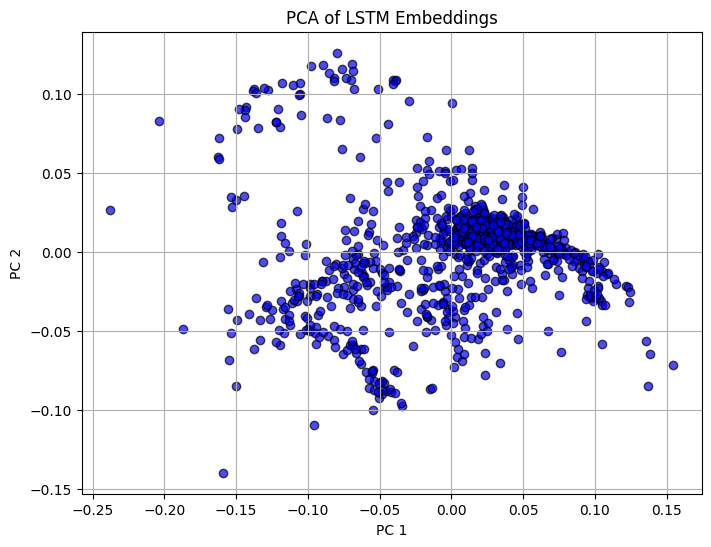

In [ ]:
visualize_embeddings(betas)